In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import scipy.io
import os
import sys
import pandas as pd
from PIL import Image

import scipy.io

from defects import *

In [2]:
# image_list = glob.glob(r"D:\work\nematics\nematics\nematics\_bacteria\hbec_images\raw\test_flow\*tif")
image_list = glob.glob(r"C:\Users\user\Desktop\work\nematics\nematics\nematics\Ken\IO\raw_images\hbec\*tif")

from natsort import natsorted
image_list = natsorted(image_list, key=lambda y: y.lower())



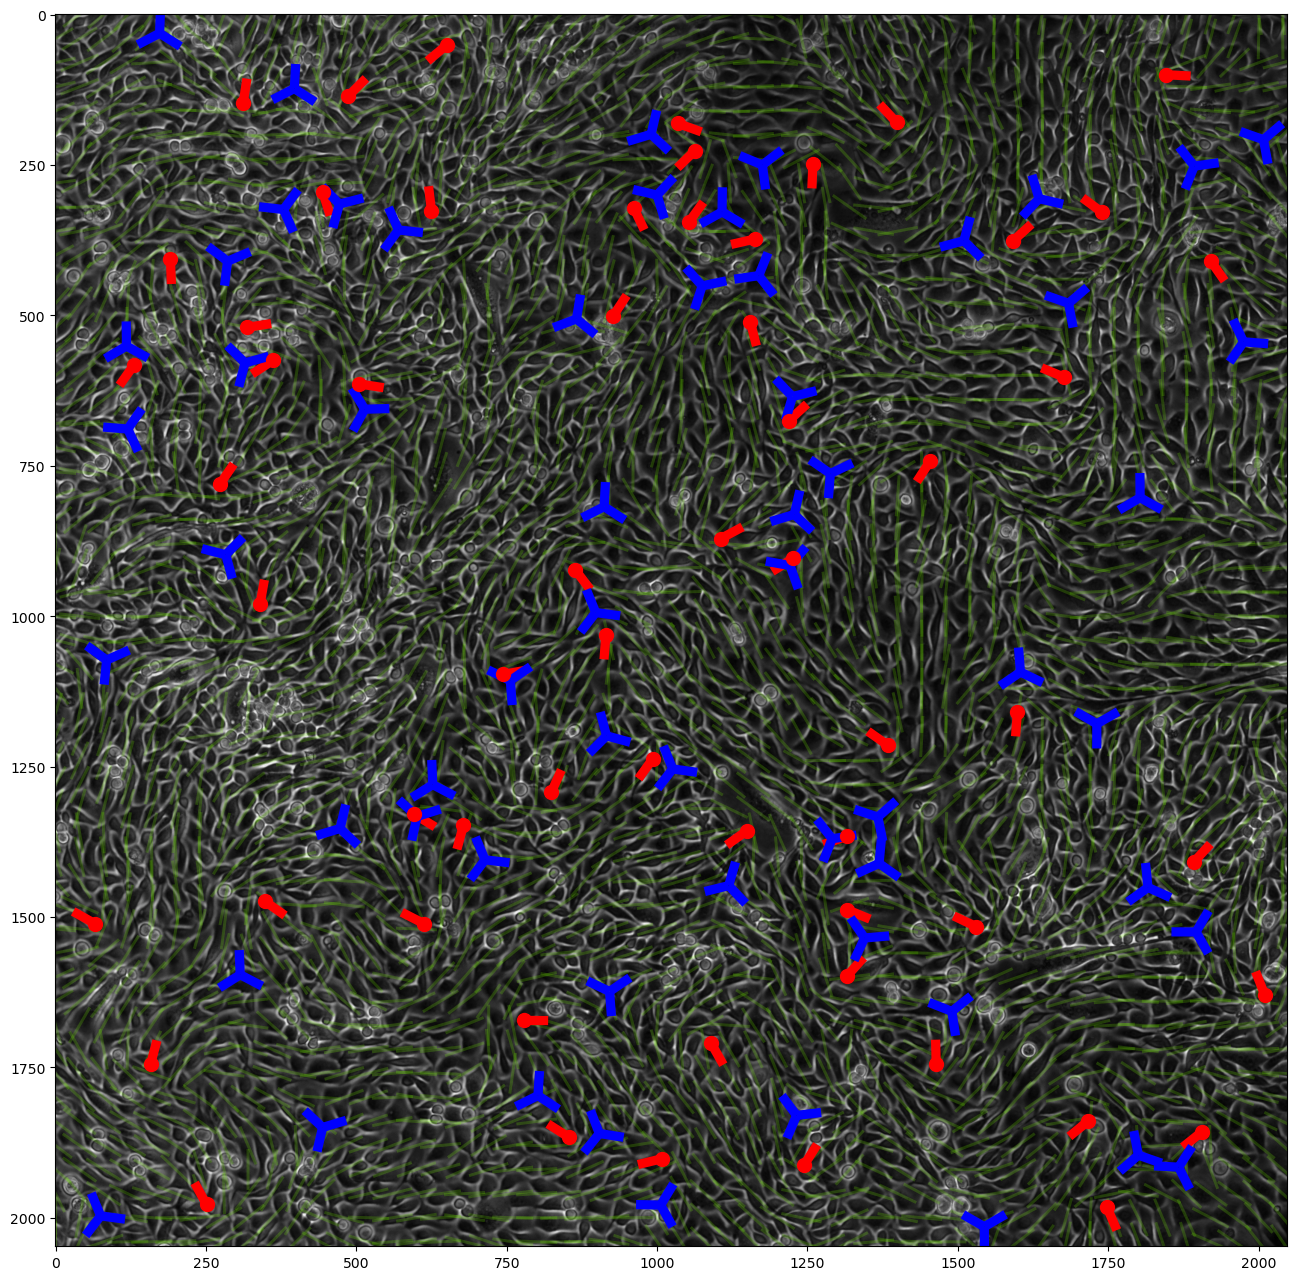

In [3]:
PLOT  = True
SAVE = False

x, y = 0, 0
win1, win2 = 600, 600
window_size = 40

for img_idx,im in enumerate(image_list):
    
    img = plt.imread(im)
    # img = img[-np.min(img.shape):,-np.min(img.shape):]
    pix_x = img.shape[1]
    pix_y = img.shape[0]

    x = np.arange(0,pix_x)
    y = np.arange(0,pix_y)
    xx,yy = np.meshgrid(x,y)

    ori, coh, E = orientation_analysis(img, window_size)
    k = compute_topological_charges(ori, int_area='cell', origin='upper')
    defects = localize_defects(k, x_grid=xx, y_grid=yy)
    compute_defect_orientations(ori, defects)
    plushalf = defects[defects['charge']==.5]
    minushalf = defects[defects['charge']==-.5]
    
    #### PLOT the image 
    if PLOT:
        
        fig, ax  = plt.subplots(figsize=(16,16))
        s = window_size 
        ax.imshow(img, cmap='gray')
        # ax.quiver(xx[::s,::s], yy[::s,::s])
        ax.quiver(xx[::s,::s], yy[::s,::s], 
            np.cos(ori)[::s,::s], np.sin(ori)[::s,::s], 
            headaxislength=0, headwidth=0, headlength=0, 
            color='lawngreen', scale=30, pivot='mid', alpha=.2)

        ax.plot(plushalf['x'], plushalf['y'],'ro',markersize=10,label=r'+1/2 defect')
        ax.quiver(plushalf['x'], plushalf['y'], 
            np.cos(plushalf['ang1']), np.sin(plushalf['ang1']), 
            headaxislength=0, headwidth=0, headlength=0, color='r', scale=50)

        for i in range(3):
            ax.quiver(minushalf['x'], minushalf['y'], 
                np.cos(minushalf['ang'+str(i+1)]), np.sin(minushalf['ang'+str(i+1)]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=50)

    if SAVE:
       plt.savefig(f"test_from_{img_idx}") 
    
    break




In [ ]:
PLOT  = True
SAVE = False

x, y = 0, 0
win1, win2 = 600, 600

for (i,im1), im2 in zip(enumerate(image_list[:-1]),image_list[1:]):

    img1 = cv2.imread(im1)[:,:,0]
    img2 = cv2.imread(im2)[:,:,0]

    # fig, axs = plt.subplots(2,1)
    # axs = axs.flatten()
    # axs[0].imshow(img1, cmap="gray")
    # axs[1].imshow(img2, cmap="gray")


    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=61, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

    if PLOT:
        fig = plt.figure(figsize=(15,10))
        step = 15
        plt.imshow(img1, cmap="gray")
        # x, y = np.arange(0, flow.shape[1], step), np.arange(flow.shape[0]-step, -1, -step)
        x = np.arange(0, flow.shape[1], step, dtype=np.int32)
        y = np.arange(0, flow.shape[0], step, dtype=np.int32)
        plt.quiver(x,y, 
                flow[::step, ::step, 0], -flow[::step, ::step, 1], color="red")
        # plt.tight_layout()
        plt.show()
        save_path = os.path.join(os.path.dirname(image_list[i]),'flow_%d.png' % i)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path)
        plt.cla()
    

    
    if SAVE:
        save_path = os.path.join(
            os.path.dirname(image_list[i]), 
            'OptFlow', 
            os.path.splitext(os.path.basename(image_list[i]))[0] + '.mat'
            )
        # break
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        scipy.io.savemat(save_path, dict(u=flow[:,:,0], v=flow[:,:,1]))
        # "C:\Users\USER\Downloads\B-sub-sur-minus-in-supernatant-40X-100fps\OptFlow\test.mat"


    # break



### test class workflow on 5 images

In [4]:
path =r"C:\Users\user\Desktop\work\nematics\nematics\nematics\Ken\IO\raw_images\test"
from workflow import *

WF = image_series(path, save_flow= True)
PH,MH = WF.detect_minus_plus()
WF.get_flow()
velocity = np.load(r"C:\Users\user\Desktop\work\nematics\nematics\nematics\Ken\IO\raw_images\velocity\velocity_from_Trans__s2_0000.npy")


In [ ]:

image_list = glob.glob(r"C:\Users\user\Desktop\work\nematics\nematics\nematics\Ken\IO\raw_images\hbec\*tif")

image_list = natsorted(image_list, key=lambda y: y.lower())
image_list = image_list[::10]

save_path = os.path.normpath(image_list[0] 
    + os.sep + os.pardir
    + os.sep + os.pardir) + '\\velocity\\' #go back two dis and go to velocity


for (i,im1), im2 in zip(enumerate(image_list[:-1]),image_list[1:]):

    methods = ['cv2.TM_CCOEFF']
    # pad = 200

    img1 = cv2.imread(im1)[:,:,0]
    img2 = cv2.imread(im2)[:,:,0]
    
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=61, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    
    
    name = 'velocity_from_' + image_list[i].split('\\')[-1].split('.')[0] + 'mat' #

    scipy.io.savemat(save_path+name, dict(u=flow[:,:,0], v=flow[:,:,1]))
    # im = Image.fromarray(padded)
    # im.save()

    
    if i > 2: 
        break

In [2]:
bigarr = WF.get_flow()

### run the velocity on all images in hbek

In [3]:
# path = r"D:\work\nematics\nematics\nematics\Ken\IO\raw_images\hbec"
# from workflow import *

# WF = image_series(path, save_flow= True)
# WF.get_flow()

array([[[[-1.52129054,  2.81112671],
         [-1.5262723 ,  2.78933191],
         [-1.52392256,  2.75258303],
         ...,
         [-4.44611025, -2.26433063],
         [-4.43628883, -2.27905607],
         [-4.42350435, -2.29885387]],

        [[-1.51156509,  2.78405905],
         [-1.51693332,  2.76504326],
         [-1.51485121,  2.73073196],
         ...,
         [-4.44432545, -2.28160024],
         [-4.43368244, -2.29513407],
         [-4.4205761 , -2.3132093 ]],

        [[-1.50256097,  2.76087356],
         [-1.50824797,  2.7439239 ],
         [-1.50635993,  2.71146727],
         ...,
         [-4.44202185, -2.30841088],
         [-4.43131018, -2.32231164],
         [-4.41798544, -2.33858109]],

        ...,

        [[ 0.748025  , -1.15709507],
         [ 0.7543816 , -1.07166576],
         [ 0.75118059, -0.98489088],
         ...,
         [ 0.14203179, -0.30388096],
         [ 0.13627288, -0.29478443],
         [ 0.13081902, -0.28654373]],

        [[ 0.70221305, -1.14178407

## crop and tilt

In [5]:
import matplotlib.pyplot as plt
from workflow import *
import cv2
from natsort import natsorted
#load

# images in path need to have a name sorted in lexicografical 
# order according to the time they where taken

image_list = r"C:\Users\user\Desktop\work\nematics\nematics\nematics\Ken\IO\raw_images\test"
img_ser = image_series(image_list)


In [6]:
#get DataFrame
df_plus, df_minus= img_ser.detect_minus_plus()
flow = img_ser.get_flow()
defect_df = pd.concat([df_plus, df_minus])

#replace values of from image with 
image_names = natsorted(defect_df['from_img'].unique(), key=lambda y: y.lower())
image_dict = {name: idx for idx,name in enumerate(image_names)}
defect_df.replace({'from_img' : image_dict})





,charge,x,y,x_ind,y_ind,ang1,ang2,ang3,from_img
60,0.5,650.0,51.0,650,51,3.835051,NaN,NaN,0
61,0.5,1846.0,100.0,1846,100,-0.052612,NaN,NaN,0
62,0.5,487.0,135.0,487,135,0.783019,NaN,NaN,0
63,0.5,312.0,147.0,312,147,1.420821,NaN,NaN,0
64,0.5,1398.0,179.0,1398,179,2.324804,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
56,-0.5,437.0,1862.0,437,1862,2.282394,4.376789,6.471184,4
57,-0.5,1829.0,1888.0,1829,1888,1.515975,3.610370,5.704765,4
58,-0.5,43.0,1996.0,43,1996,1.902032,3.996428,6.090823,4
59,-0.5,1918.0,2001.0,1918,2001,2.158546,4.252941,6.347336,4


In [5]:

half_size = 200
sq_image_shape = 2048
for idx,row in defect_df.iterrows():

    #get window around defect 
    x,y = row['x_ind'],row['y_ind']
    x_start,x_stop = x- half_size , x + half_size
    y_start, y_stop = y - half_size, y + half_size
    if (y_stop > sq_image_shape) or (x_stop > sq_image_shape) or (x_start < 0) or (y_start < 0):
        continue

    x_range = np.arange(x_start,x_stop)
    y_range = np.arange(y_start,y_stop)
    window = np.meshgrid(x_range, y_range)
    print(idx,window)
    break
    

66 [array([[ 863,  864,  865, ..., 1260, 1261, 1262],
       [ 863,  864,  865, ..., 1260, 1261, 1262],
       [ 863,  864,  865, ..., 1260, 1261, 1262],
       ...,
       [ 863,  864,  865, ..., 1260, 1261, 1262],
       [ 863,  864,  865, ..., 1260, 1261, 1262],
       [ 863,  864,  865, ..., 1260, 1261, 1262]]), array([[ 26,  26,  26, ...,  26,  26,  26],
       [ 27,  27,  27, ...,  27,  27,  27],
       [ 28,  28,  28, ...,  28,  28,  28],
       ...,
       [423, 423, 423, ..., 423, 423, 423],
       [424, 424, 424, ..., 424, 424, 424],
       [425, 425, 425, ..., 425, 425, 425]])]


### rotate the image around its center

## test the rotation

### crop the image 

In [1]:
import scipy as sp 
import workflow
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# img = workflow.image(r"C:\Users\user\Desktop\work\nematics\nematics\nematics\Ken\IO\raw_images\test\square.png")
# im = plt.imread(r"C:\Users\user\Desktop\work\nematics\nematics\nematics\Ken\IO\raw_images\test\square.png")
# center = (int((im.shape[0] -1) / 2),int((im.shape[1] -1) / 2))
# angle = 0.866
# Data = {'x_ind':[center[0]],'y_ind':[center[1]],'ang1': [angle],'from_img': 'test'}
# defect_df_like = pd.DataFrame(Data)
# # vel_arr = np.random.random((*im.shape[:2],2))
# vel_arr = im
# ori_arr = np.random.random(im.shape[:2])

# img.crop_and_tilt(
#     defects_df= defect_df_like,
#     velocity_array= vel_arr,
#     orientation_array= ori_arr,
#     half_window= 100,
#     save = True
# )


# tst = np.load(r"C:\Users\user\Desktop\work\nematics\nematics\nematics\Ken\IO\raw_images\velocity_around_defect\test.npy")
# plt.imshow(tst)

In [2]:
img = workflow.image(r"C:\Users\user\Desktop\work\nematics\nematics\nematics\Ken\IO\raw_images\test\Trans__s2_0000.tif")
velocity = np.load(r"C:\Users\user\Desktop\work\nematics\nematics\nematics\Ken\IO\raw_images\velocity\velocity_from_Trans__s2_0000.npy")
img.crop_and_tilt(save= True, velocity_array= velocity)


In [3]:
img.crop_and_tilt(save= True, velocity_array= velocity)

In [3]:
around = np.load(r"C:\Users\user\Desktop\work\nematics\nematics\nematics\Ken\IO\raw_images\velocity_around_defect\Trans__s2_0000.npy")
around

array([[[ 4.09928122,  4.23250368],
        [ 4.05947741,  4.28795243],
        [ 4.01577635,  4.3441808 ],
        ...,
        [-1.05802203,  5.80624333],
        [-1.15114883,  5.82592642],
        [-1.26793931,  5.85542899]],

       [[ 4.07700176,  4.31973242],
        [ 4.04461755,  4.38514883],
        [ 4.00637495,  4.4449786 ],
        ...,
        [-1.02585111,  5.82131729],
        [-1.12268513,  5.84633519],
        [-1.23366696,  5.88045869]],

       [[ 4.05532172,  4.4081162 ],
        [ 4.02438378,  4.47519801],
        [ 3.99082005,  4.53430114],
        ...,
        [-1.0093926 ,  5.8452738 ],
        [-1.10745769,  5.8749685 ],
        [-1.20751919,  5.90721529]],

       ...,

       [[ 0.75483956,  2.92164359],
        [ 0.77458562,  2.97678479],
        [ 0.80925577,  3.08636558],
        ...,
        [ 1.97202036, -2.41643129],
        [ 2.00204946, -2.40571717],
        [ 2.03384235, -2.40104472]],

       [[ 0.75070151,  2.9256817 ],
        [ 0.76062839,  2.92